In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Table of contents

* [**1. Data preparation**](#1)
    * [**1.1 Load data**](#1.1)
    * [**1.2 Clean columns**](#1.2)
    * [**1.3 One-hot-encoding**](#1.3)
    * [**1.4 Extract relevant talents**](#1.4)
* [**2. Data visualization**](#2)
    * [**2.1 Hourly rates for Data Scientists**](#2.1)
    * [**2.2 Hourly rates by continent**](#2.2)
    * [**2.3 Total hours worked as predictor for hourly rate**](#2.3)


### Notebook description

Simple analysis of freelancing on `Upwork` as data scientist.

<a name='1'></a>
# 1. Data preparation
<a name='1.1'></a>
## 1.1 Load data

Data scraped from upwork.com `2021/09/03` - `2021/09/05` using **data science** search tearm.

In [2]:
df = pd.read_csv('data/data_science.csv', index_col=0)
df.head()

,Name,Title,Country,Rate,Earnings,Success,Badges,Description
0,Jesus Liebana L.,Data Scientist | AI | Machine Learning | Data ...,Spain,$35.00 /hr,$30k+ earned\n Close the tooltip \n...,100% Job Success,"Python, Data Science, Elasticsearch, Scala, Ja...",I'm an expert (4+ years) processing of large v...
1,Tamara A.,"Ph.D.-level Researcher, Survey Developer, Writ...",United States,$95.00 /hr,$100k+ earned\n Close the tooltip \...,100% Job Success,"Research Papers, Article Writing, Business, Su...","I am a thorough, detailed, engaged, thoughtful..."
2,Benjamin G.,Data Scientist,United States,$130.00 /hr,$10k+ earned\n Close the tooltip \n...,NaN,"R, Excel VBA, Microsoft Excel, Python, Data Sc...",I'm a data scientist with six years of profess...
3,Fabio C.,Machine Learning Engineer,Portugal,$40.00 /hr,$5k+ earned\n Close the tooltip \n ...,100% Job Success,"Machine Learning, Data Science, Translation, A...","My name is Fabio, I am a Brazilian engineer wo..."
4,Grigory A.,Machine Learning Engineer / Software Developer...,Czech Republic,$50.00 /hr,$20k+ earned\n Close the tooltip \n...,NaN,"Machine Learning, Python, D3.js, Apache Spark,...",* Ten years of experience in AI / Machine Lear...


<a name='1.2'></a>
## 1.2 Clean columns

### 1.2.1 Convert `Rates` column from string to float

In [3]:
# transport Rates columns into float dollars per hour
df.Rate = df.Rate.apply(lambda x: x.split('   /')[0][1:]).astype(float)
df.Rate.head()

0     35.0
1     95.0
2    130.0
3     40.0
4     50.0
Name: Rate, dtype: float64

### 1.2.2 Create new `Total_earnings` column from `Earnings` column

In [4]:
# example of random value (to see how data is structured)/
df.Earnings.sample(1).values

array(['$200k+ earned\n           Close the tooltip  \n            29\n            hourly jobs\n           \n            6\n            fixed-price jobs\n           \n            1921\n            hours worked'],
      dtype=object)

In [5]:
# convert column to string
df.Earnings = df.Earnings.astype(str)
# extract earnings value from column
df['Total_Earnings'] = df.Earnings.apply(lambda x: x.split('\n')[0][1:-8] if 'earned' in x else '0')
# multiply by 100 if k is present in string
df.Total_Earnings = df.Total_Earnings.apply(lambda x: int(x[:-1])*1000 if 'k' in x else int(x))

### 1.2.3 Create new `Hourly_jobs`, `Fixed_price_jobs`, column from `Earnings` column

In [6]:
# check if all length of row is the same for all cases, eihter len == x or empty len == 0
df.Earnings.apply(lambda x: len(x.split('\n')) if 'fixed-price jobs' in x else 0).unique()

# create new columns for storing data
df['Hourly_jobs'] = df.Earnings.apply(lambda x: int(x.split('\n')[2].strip()) if 'hourly jobs' in x else 0)
df['Fixed_price_jobs'] = df.Earnings.apply(lambda x: x.split('\n')[5].strip() if 'fixed-price jobs' in x else '0')
df['Hours_worked'] = df.Earnings.apply(lambda x: int(x.split('\n')[-2].strip()) if 'hours worked' in x else 0)

# convert strings, eg. 'No', to integer
df.Fixed_price_jobs = df.Fixed_price_jobs.apply(lambda x: int(x) if x.isnumeric() else 0)

# remove earnings columns
del df['Earnings']

# check results
df[['Hourly_jobs', 'Fixed_price_jobs', 'Hours_worked']].sample(5)

,Hourly_jobs,Fixed_price_jobs,Hours_worked
1750,7,7,1114
4349,2,0,2222
1687,21,22,2885
3038,3,0,253
1032,54,24,3103


<a name='1.3'></a>
## 1.3 One-hot-encode

### 1.3.1 `bages` columns

In [7]:
# remove all spaces from badges string and make all cases lower
df.Badges = df.Badges.apply(lambda x: x.replace(" ", "").lower() if isinstance(x, str) else x)
# one-hot encode
df_bages = df.Badges.str.get_dummies(sep=',')
# all available bages (column names)
badges = df_bages.columns
# merge one-hot-encoded features with DataFrame
df = pd.concat([df, df_bages], axis=1)

<a name='1.4'></a>
## 1.4 Extract relevant talents

In [8]:
# get talents wich contains data science keyword
df_ds = df.loc[df['datascience'] == 1, df.columns[:12]].copy()
print(f"Total {df_ds.shape[0]} talents found.")
# exclude talent with no logged hours worked
df_ds = df_ds[(df_ds.Hours_worked!=0)].copy()
print(f"{df_ds.shape[0]} talents with hours worked.")
df_ds.head()

Total 1185 talents found.
979 talents with hours worked.


,Name,Title,Country,Rate,Success,Badges,Description,Total_Earnings,Hourly_jobs,Fixed_price_jobs,Hours_worked,.netcf
0,Jesus Liebana L.,Data Scientist | AI | Machine Learning | Data ...,Spain,35.0,100% Job Success,"python,datascience,elasticsearch,scala,java,da...",I'm an expert (4+ years) processing of large v...,30000,5,0,1595,0
1,Tamara A.,"Ph.D.-level Researcher, Survey Developer, Writ...",United States,95.0,100% Job Success,"researchpapers,articlewriting,business,surveyd...","I am a thorough, detailed, engaged, thoughtful...",100000,61,36,1356,0
2,Benjamin G.,Data Scientist,United States,130.0,NaN,"r,excelvba,microsoftexcel,python,datascience",I'm a data scientist with six years of profess...,10000,16,4,214,0
3,Fabio C.,Machine Learning Engineer,Portugal,40.0,100% Job Success,"machinelearning,datascience,translation,artifi...","My name is Fabio, I am a Brazilian engineer wo...",5000,7,11,207,0
4,Grigory A.,Machine Learning Engineer / Software Developer...,Czech Republic,50.0,NaN,"machinelearning,python,d3.js,apachespark,stati...",* Ten years of experience in AI / Machine Lear...,20000,18,10,703,0


<a name='2'></a>
# 2.  Data visualizations
<a name='2.1'></a>
## 2.1 Hourly rates for Data Scientists

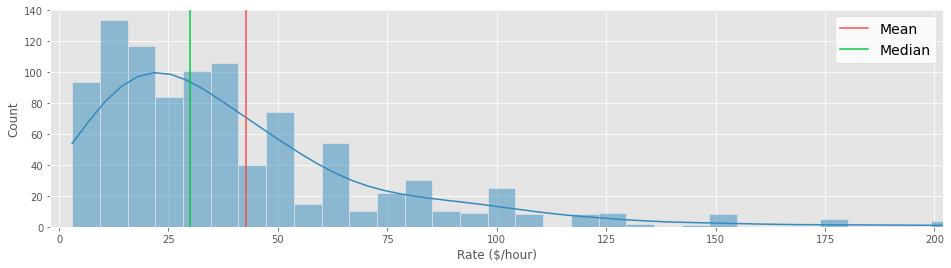

In [9]:
# visualize salary histogram
fig, ax = plt.subplots(figsize=(16, 4))

sns.histplot(df_ds['Rate'], ax=ax, kde=True)
ax.set_xlabel('Rate ($/hour)')
# manually add limits for x-axis to exclude outlier values
ax.set_xlim(-2, 202)

# calculate statistics and plot statistics
ax.axvline(df_ds['Rate'].mean(), label='Mean', color='#ff4d4d')
ax.axvline(df_ds['Rate'].median(), label='Median', color='#00cc44')

legend = ax.legend(fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('w');

<a name='2.2'></a>
## 2.2 Hourly rates by continent

In [10]:
import pycountry_convert as pc

# handle naming exceptions
df_ds.Country = df_ds.Country.str.replace('Palestinian Territories', 'Palestine')

def country_2_continent(x):
    """
    Input:
        x: string
    Returns continent name
    """
    country_code = pc.country_name_to_country_alpha2(x, cn_name_format="default")
    return pc.country_alpha2_to_continent_code(country_code)

df_ds['Continent'] = df_ds.Country.apply(lambda x: country_2_continent(x))
# rename continents
df_ds.Continent =  df_ds.Continent.replace({'EU': "Europe", 'NA': 'North America', 'AS': 'Asia',
                                            'SA': 'South America', 'AF': 'Africa', 'OC': 'Oceania'})

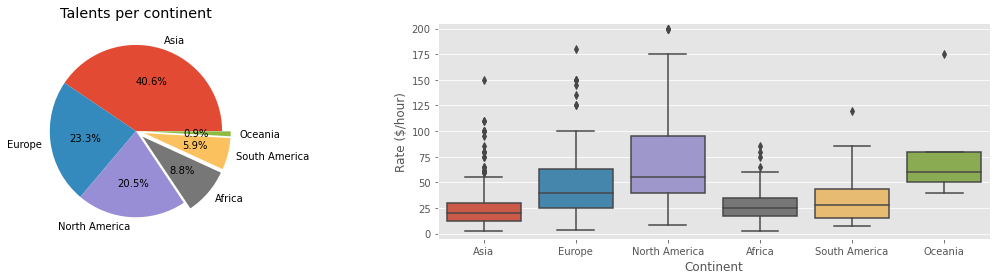

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs = axs.flatten()

# pie chart
pie_data = df_ds.Continent.value_counts()
# extrude parts of data for better visibility
explode = [0, 0, 0, 0.1, 0.1, 0.1]
axs[0].pie(pie_data.values, labels = pie_data.index.values, autopct='%.1f%%', explode=explode)
axs[0].set_title('Talents per continent')

# Box-plot (vizualize hourly rate variations)
sns.boxplot(x="Continent", y="Rate", data=df_ds, ax=axs[1], order=pie_data.index.values)
# add limits to exclude outliers
axs[1].set_ylim(-5, 205)
axs[1].set_ylabel('Rate ($/hour)')

plt.tight_layout()

<a name='2.3'></a>
## 2.3 Total hours worked as `predictor` for hourly rate 

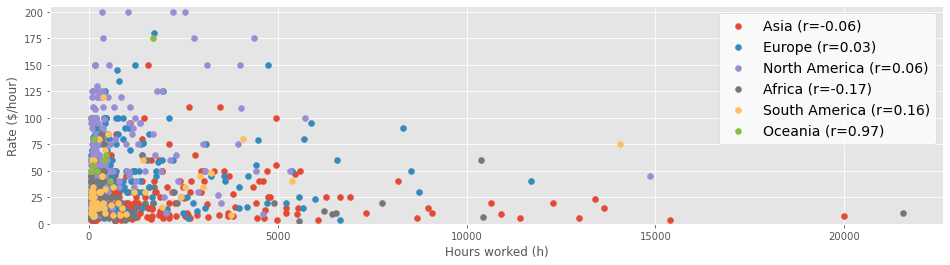

In [12]:
fig, ax = plt.subplots(figsize=(16, 4))

for continent in pie_data.index.values:
    _df_plot = df_ds.loc[df_ds.Continent == continent].copy()
    # Pear. Corr. Coeficient
    _pear = _df_plot[['Hours_worked', 'Rate']].corr().values[0][1]
    
    ax.scatter(_df_plot.Hours_worked, _df_plot.Rate, label=f"{continent} (r={_pear:.2f})")
    
ax.set_xlabel('Hours worked (h)')
ax.set_ylabel('Rate ($/hour)')
ax.set_ylim(0, 205)

legend = ax.legend(fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('w');

<a name='2.4'></a>
## 2.4 Complimentary skills for data scientist 

In [13]:
# create set off all keywords without data science tag
badges_set = set(badges) - {'datascience'}
info = list()

for badge in badges_set:
    # find how many times spesific keyword appeared (only for talents with experience)
    info.append([badge, df.loc[df_ds.index, badge].sum()]) 
    
# store information about tags in DataFrame
df_skills = pd.DataFrame(info, columns=['tag', 'counts']).sort_values(by='counts')

top_15_skills = pd.DataFrame(info, columns=['tag', 'counts']).sort_values(by='counts').tail(15)
# manually rename tags for better readability
rename_dict = {'dataentry': 'Data Entry', 'datascraping': 'Data Scraping', 'statistics': 'Statistics',
               'tensorflow': 'Tensorflow', 'webscraper': 'Web scraper', 'microsoftexcel': 'Microsoft Excel',
               'naturallanguageprocessing': 'Natural Language Processing', 'sql': 'SQL',
               'datavisualization': 'Data Visualization', 'r': 'R', 'deeplearning': 'Deep Learning',
               'datamining': 'Data Mining', 'machinelearning': 'Machine Learning', 'python': 'Python'}

top_15_skills.tag = top_15_skills.tag.replace(rename_dict)
# convert coutns to percentages
top_15_skills.counts = top_15_skills.counts / df_ds.shape[0] * 100

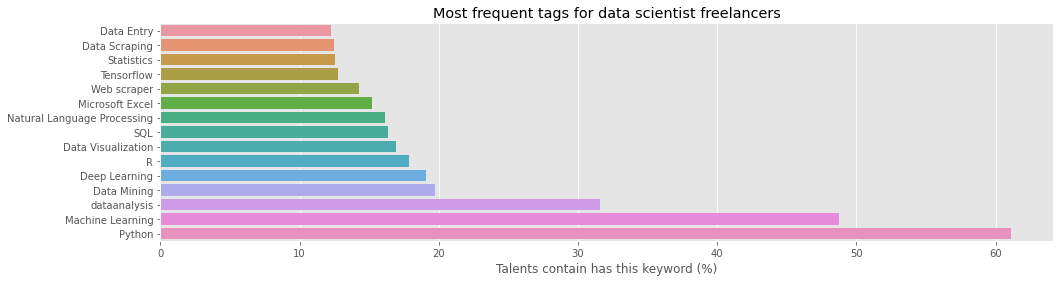

In [14]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.barplot(x=top_15_skills.counts, y=top_15_skills.tag, ax=ax)

ax.set_title('Most frequent tags for data scientist freelancers')
ax.set_xlabel('Talents contain has this keyword (%)')
ax.set_ylabel('');